In [1]:
import math                       
import matplotlib.pyplot as plt   
import random                     
import numpy as np                
import numpy.linalg as lin        
import scipy.special as ss
import pickle
import multiprocessing
import time
import pandas as pd
import sys
import csv
import seaborn as sns

In [2]:
# Import Functions
import hdc

In [3]:
#Set Parameters
D = 5000
Q = 16
d = 0.05
remove_list = []

In [4]:
#Import ISOLET Dataset 
with open('isolet.pkl', 'rb') as f:
    isolet = pickle.load(f)
trainData, trainLabels, testData, testLabels = isolet
trainData = np.array(trainData)
testData = np.array(testData)

Create item memory manually by running the next cell or import previously created item memory.

In [5]:
#Create item memory
voice_im = hdc.create_item_mem(Q,D,d)
im = pd.DataFrame(voice_im.values())
im.to_csv('im.csv', index=False, header=False)

In [5]:
#Import item Memory
voice_im = np.array(pd.read_csv("im.csv",header = None).values.tolist())
voice_im = dict(zip(range(26),voice_im))
print(voice_im.items())

dict_items([(0, array([0, 0, 0, ..., 0, 0, 0])), (1, array([0, 0, 0, ..., 0, 0, 0])), (2, array([0, 0, 0, ..., 0, 0, 0])), (3, array([0, 0, 0, ..., 0, 0, 0])), (4, array([0, 0, 0, ..., 0, 0, 0])), (5, array([0, 0, 0, ..., 0, 0, 0])), (6, array([0, 0, 0, ..., 0, 0, 0])), (7, array([0, 0, 0, ..., 0, 0, 0])), (8, array([0, 0, 0, ..., 0, 0, 0])), (9, array([0, 0, 0, ..., 0, 0, 0])), (10, array([0, 0, 0, ..., 0, 0, 0])), (11, array([0, 0, 0, ..., 0, 0, 0])), (12, array([0, 0, 0, ..., 0, 0, 0])), (13, array([0, 0, 0, ..., 0, 0, 0])), (14, array([0, 0, 0, ..., 0, 0, 0])), (15, array([0, 0, 0, ..., 0, 0, 0]))])


In [6]:
encoding_threshold = 32
training_threshold = 40

In [9]:
confusion_mtx = np.zeros((26,26))
print(encoding_threshold,training_threshold)
trials = 1
for trial in range(trials):
    print("Trial:",trial+1)
    keys = range(26)
    voice_am = dict()

    non_bin_reg = np.zeros((26,D))
    cores = multiprocessing.cpu_count()
    print('cores used:',cores)
    print('Training...')

    # Create the process pool
    enc_start = time.time()
    with multiprocessing.Pool(cores) as pool:
        args = [(trainData[i],voice_im,D,d,Q,encoding_threshold) for i in range(len(trainLabels))]
        results = pool.starmap(hdc.hdc_encode,args)
    #print('encode_time',time.time()-enc_start)
    print('Encoded HV Density:',sum([sum(results[i]) for i in range(len(trainData))])/(D*len(trainData)))
    
    for i in range(len(trainLabels)):
        non_bin_reg[trainLabels[i]] = np.add(non_bin_reg[trainLabels[i]],results[i])
    #non_bin_reg, remove_list = dimension_sparsifier(non_bin_reg, D, d, remove_list)
    
    for i in range(len(keys)):
        voice_am[keys[i]] = np.where(non_bin_reg[i]>training_threshold,1,0)
        #print(i,sum(voice_am[keys[i]]))
    print('AM HV Density:',sum([sum(list(voice_am.items())[i][1]) for i in range(len(keys))])/(D*len(keys)))
    
    # Iterate through all elements in the clean_letters set
    print('Testing')
    test_data = testData
    correct_values = testLabels
    print_flag = False
    score = 0
    test_len = len(test_data)
    #cores = multiprocessing.cpu_count()

    with multiprocessing.Pool(cores) as pool:
        arg = [(test_data[i],voice_im,voice_am,D,d,Q,encoding_threshold,remove_list) for i in range(test_len)]
        result = pool.map(hdc.search,arg)

    #print(len(result))
    enc_t = 0
    s_t = 0
    for i in range(test_len):
        sim_letter, sim_score = result[i][0],result[i][1]
        enc_t += result[i][2]
        s_t += result[i][3]
        if sim_letter == correct_values[i]:
            score += 1
            confusion_mtx[correct_values[i]][sim_letter] += 1
            if(print_flag):
                print("CORRECT prediction! sim_letter: ", sim_letter, " sim_score: ", str(sim_score))
        else:
            confusion_mtx[correct_values[i]][sim_letter] += 1
            if(print_flag):
                print("WRONG prediction! sim_letter: " , sim_letter, " sim_score: ", str(sim_score))
    #print(enc_t,s_t)
    #print("Final accuracy is: %f" % ((score*100/test_len)))
    print('Accuracy:',(score*100/test_len))
    for i in range(26):
        for j in range(26):
            print(round(confusion_mtx[i][j]/(1*trials),3),end=',')
        print()

32 40
Trial: 0
cores used: 4
Training...
Encoded HV Density: 0.36900006412311637
AM HV Density: 0.4937923076923077
Testing
Accuracy: 78.06286080821039
44.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,
0.0,39.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,
0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,3.0,
0.0,5.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,4.0,1.0,2.0,3.0,0.0,0.0,0.0,
0.0,17.0,0.0,3.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,
0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,
0.0,0.0,0.0,2.0,0.0,0.0,34.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,17.0,0.0,1.0,2.0,0.0,0.0,0.0,
2.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

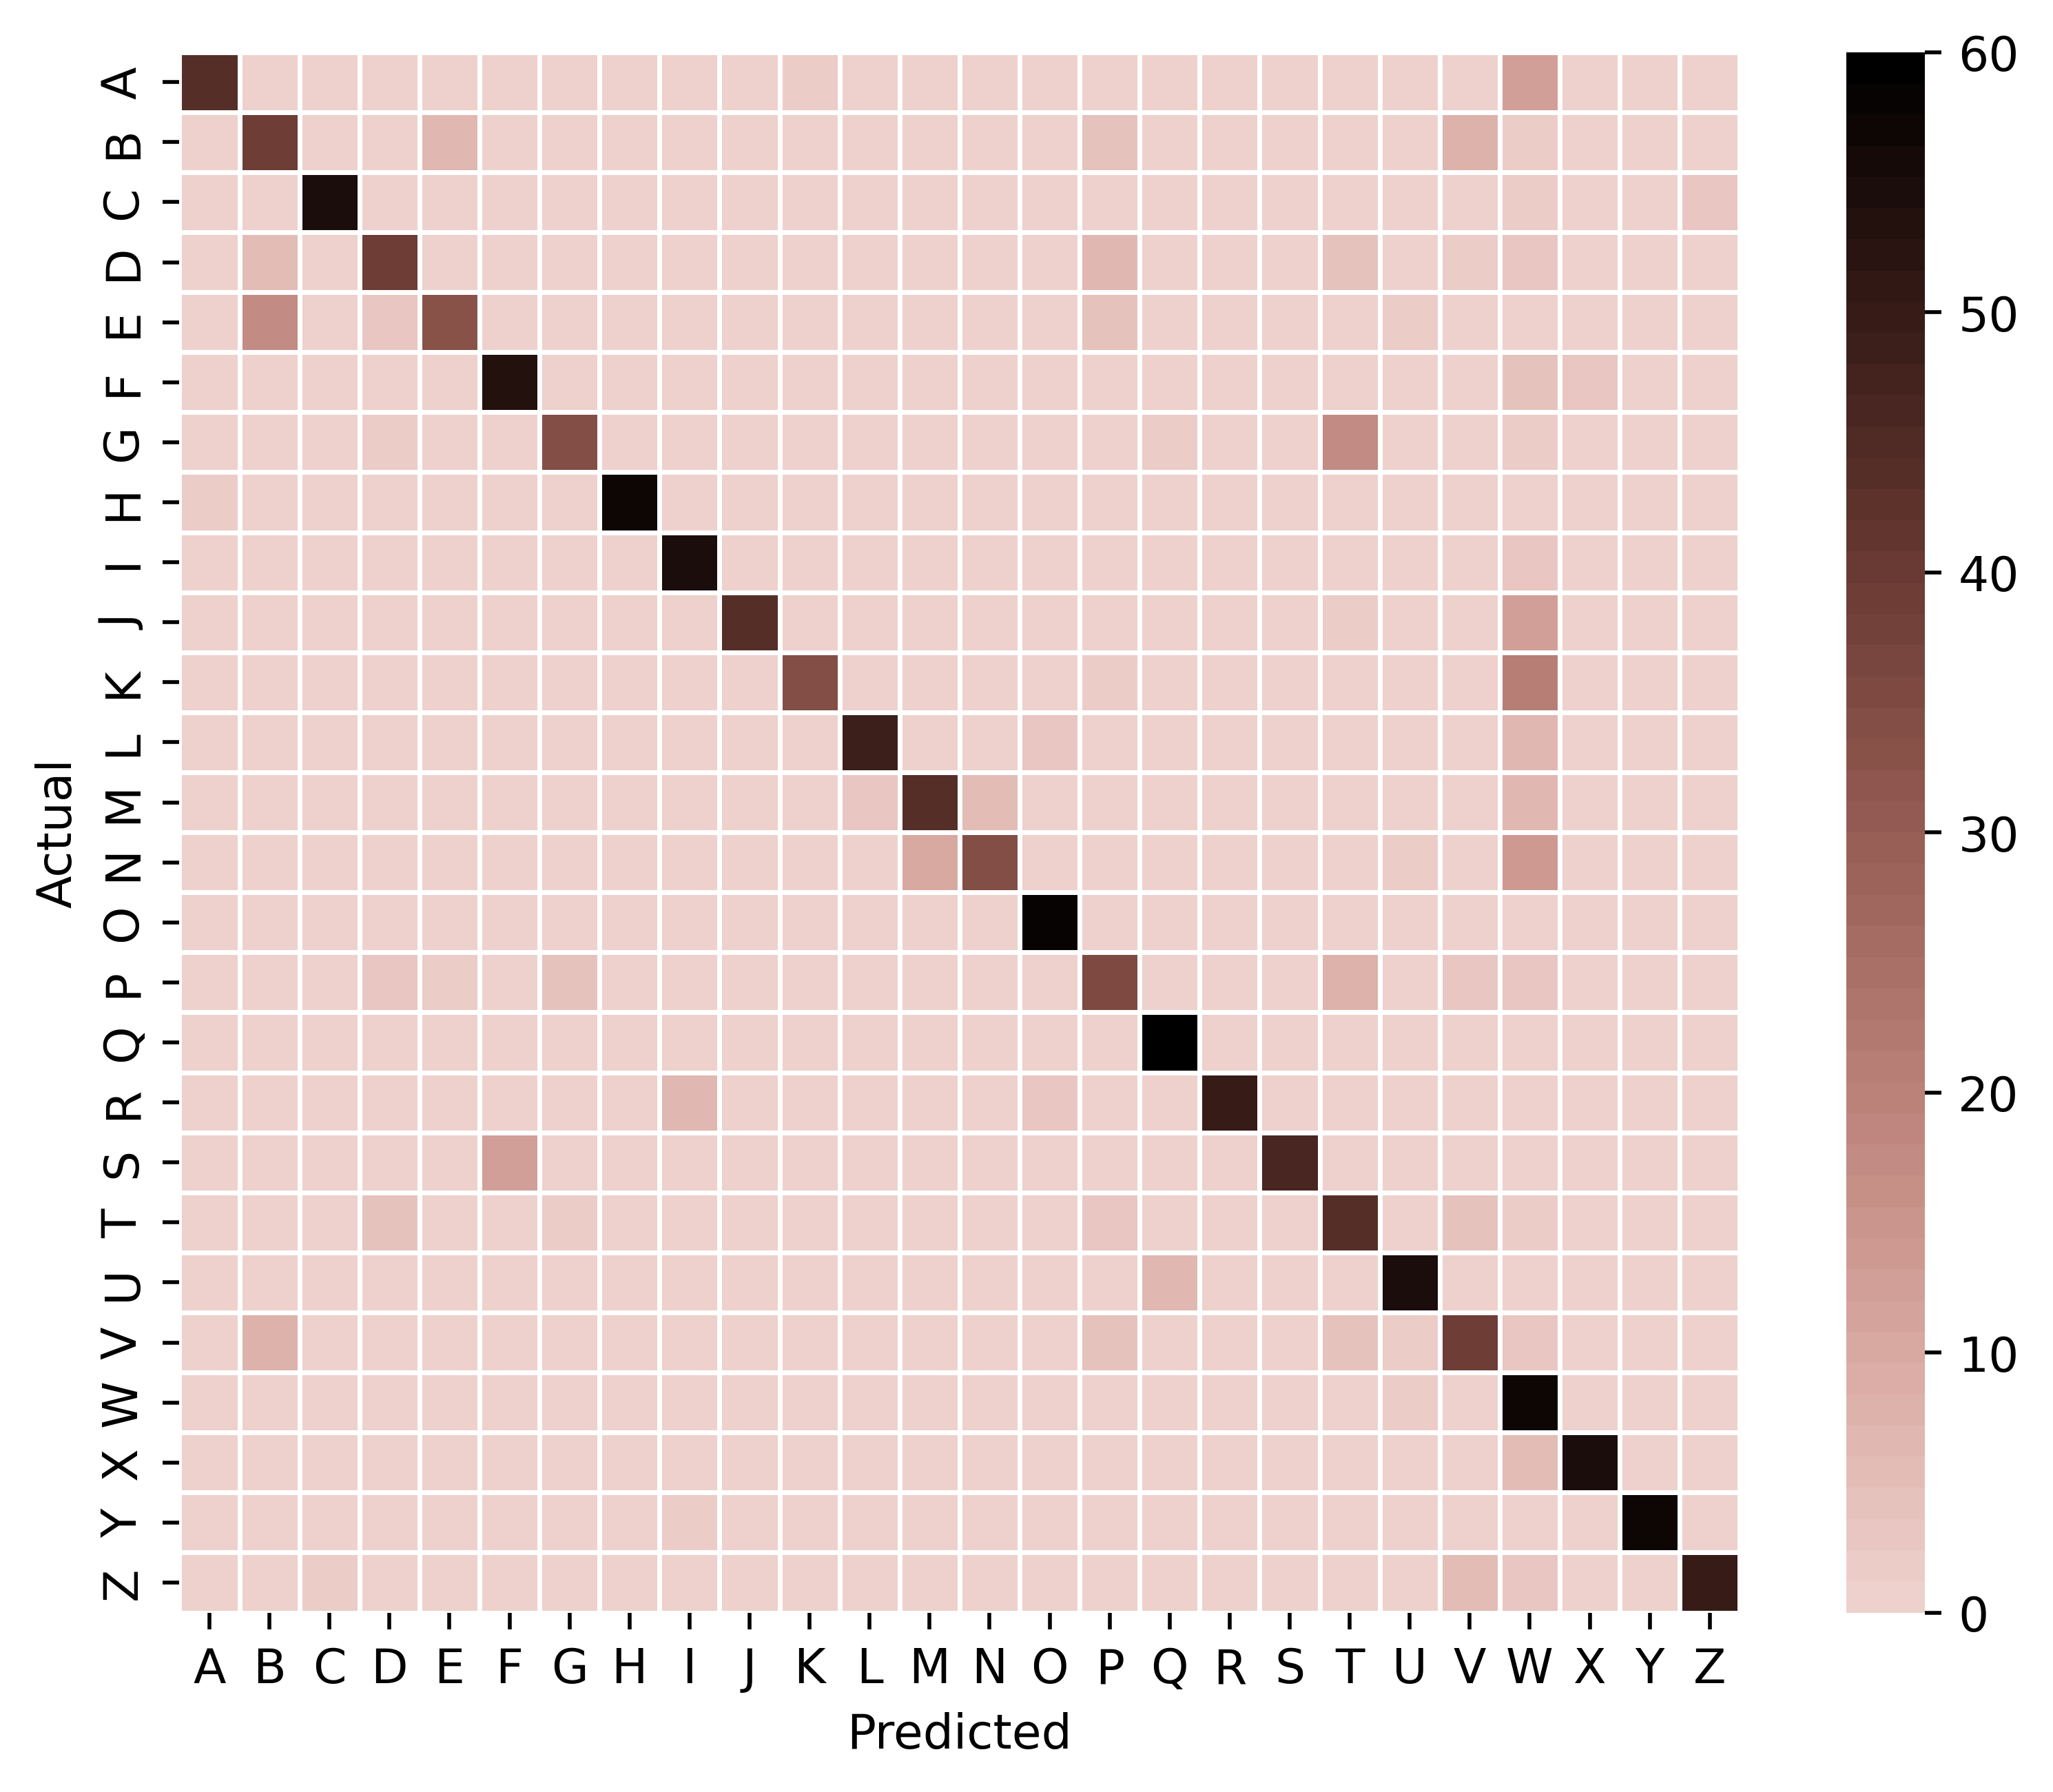

In [10]:
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['figure.dpi'] = 500
alphabet = [chr(i+65) for i in range(26)]
#sns.palplot(sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0))
cmap = sns.cubehelix_palette(n_colors=50, start=1, rot=0, light=0.85, dark=0)
ax = sns.heatmap(confusion_mtx,xticklabels=alphabet,yticklabels=alphabet,square=True,cmap=cmap,linewidths=1,linecolor='white')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()